# Topic Modelling

In [1]:
# include notebooks dataset processing cordis & nsf

## 0. Libraries

In [2]:
# Data processing
import pandas as pd
import numpy as np

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Lemmatization
import spacy

# Vectorization
import gensim

# Topic modelling
from gensim.models.wrappers import LdaMallet
from customMallet import CustomMallet
mallet_path = '/Users/celiaromerogonzalez/Mallet/bin/mallet'
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.wrappers.ldamallet import malletmodel2ldamodel

# Document LDA representation
import pyLDAvis.gensim as gensimvis
import pyLDAvis

import warnings
warnings.filterwarnings('ignore')

## 1. Creating dataframe

Read CSVs corresponding to Cordis and NSF datasets. Only the columns of interest are imported.

### 1.1 Cordis dataset

In [4]:
cordish2020 = pd.read_csv("data/cordis/cordis-h2020projects.csv",sep=";",usecols=['id','objective'])
cordisfp6 = pd.read_csv("data/cordis/cordis-fp6projects.csv",sep=";",usecols=['id','objective'])
cordisfp7 = pd.read_csv("data/cordis/cordis-fp7projects.csv",sep=";",usecols=['id','objective'])
cordis = cordish2020.append(cordisfp7)
cordis = cordis.append(cordisfp6)

# cordis = pd.read_csv("data/cordis/cordis.csv",sep=";",usecols=['id','objective'])

print('Cordis null abstracts: %d (%.4f %%)' % (cordis['objective'].isnull().sum(),cordis['objective'].isnull().sum()/cordis.shape[0]))
print('Cordis shape with null abstracts: ',cordis.shape)
cordis = cordis[cordis['objective'].notna()]
print('Cordis shape without null abstracts: ',cordis.shape)
cordis['objective'].isnull().sum()

Cordis null abstracts: 160 (0.0024 %)
Cordis shape with null abstracts:  (68021, 2)
Cordis shape without null abstracts:  (67861, 2)


0

### 1.2 NSF dataset

In [5]:
nsf = pd.read_csv('data/nsf/nsf.csv',usecols=['AwardID','AbstractNarration'])

print('NSF null abstracts: %d (%.4f %%)' % (nsf['AbstractNarration'].isnull().sum(),nsf['AbstractNarration'].isnull().sum()/nsf.shape[0]))
print('NSF shape with null abstracts: ',nsf.shape)
nsf = nsf[nsf['AbstractNarration'].notna()]
print('NSF shape without null abstracts: ',nsf.shape)
nsf['AbstractNarration'].isnull().sum()

NSF null abstracts: 7857 (0.0114 %)
NSF shape with null abstracts:  (688506, 2)
NSF shape without null abstracts:  (680649, 2)


0

### 1.3 Join dataframes

In [7]:
# Add column with source of documents
cordis['org'] = 'EU'
nsf['org'] = 'NSF'

# Rename columns to match headers later
cordis = cordis.rename(columns={'objective':'abstract'})
nsf = nsf.rename(columns={'AwardID':'id','AbstractNarration':'abstract'})

# Join dataframes into 1
corpusdata = cordis.append(nsf)
corpusdata

,id,abstract,org
0,672890,'The project targets all luxury fashion firms ...,EU
1,633814,EU's agricultural and forestry land provides a...,EU
2,785419,"According to the Global Market Forecast, there...",EU
3,721362,In the aerospace industry very high quality st...,EU
4,861924,Large areas of agricultural land in W. and N. ...,EU
...,...,...,...
688501,1.61448e+06,A few micro-seconds after the Big Bang the uni...,NSF
688502,1.62455e+06,Calcium sulfate in crystalline form (anhydrite...,NSF
688503,1.6047e+06,The Rocky Mountain-Great Plains Graduate Resea...,NSF
688504,1.65392e+06,Investments made across national boundaries cr...,NSF


In [8]:
corpusdata.org.value_counts()

NSF    680649
EU      67861
Name: org, dtype: int64

## 2. Lemmatization with Spacy

... explain ...

### 2.1 Lemmatize

In [10]:
nlp = spacy.load('en_core_web_md')
nlp.disable_pipe('parser')
nlp.disable_pipe('ner')

valid_POS = set(['VERB', 'NOUN', 'ADJ', 'PROPN'])

def text_preprocessing(rawtext):
    lemmatized = ' '.join([token.lemma_ for token in doc 
                           if token.is_alpha
                           and token.pos_ in valid_POS
                           and not token.is_stop])
    return lemmatized

"""
corpusdata['lemmas'] = None

for i in range(len(corpusdata)):
    if not i%10000:
        print('Preprocessing abstract %d out of %d' % (i,len(corpusdata['abstract'])))
    doc = nlp(corpusdata['abstract'].iloc[i])
    corpusdata['lemmas'].iloc[i] = text_preprocessing(doc)

corpusdata.to_csv('data/corpusdata_lemmatized.csv',sep=';',index=False)

corpusdata.head()

"""

# OR

corpusdata = pd.read_csv('data/corpusdata_lemmatized.csv',sep=';')
corpusdata

,id,abstract,org,lemmas
0,672890,'The project targets all luxury fashion firms ...,EU,project target luxury fashion firm manufacture...
1,633814,EU's agricultural and forestry land provides a...,EU,EU agricultural forestry land provide wide ran...
2,785419,"According to the Global Market Forecast, there...",EU,accord Global Market Forecast strong need ramp...
3,721362,In the aerospace industry very high quality st...,EU,aerospace industry high quality standard meet ...
4,861924,Large areas of agricultural land in W. and N. ...,EU,large area agricultural land Africa degrade wa...
...,...,...,...,...
748505,1.61448e+06,A few micro-seconds after the Big Bang the uni...,NSF,micro second Big Bang universe fill hot plasma...
748506,1.62455e+06,Calcium sulfate in crystalline form (anhydrite...,NSF,calcium sulfate crystalline form anhydrite mel...
748507,1.6047e+06,The Rocky Mountain-Great Plains Graduate Resea...,NSF,Rocky Mountain Great Plains Graduate Research ...
748508,1.65392e+06,Investments made across national boundaries cr...,NSF,investment national boundary create internatio...


### 2.2 Count lemmas

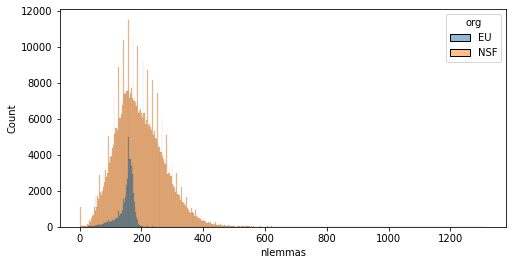

In [11]:
def count_lemmas(x):
    return len(x.split())

corpusdata = corpusdata[corpusdata['lemmas'].notna()]
corpusdata['lemmas'] = corpusdata['lemmas'].str.lower()
corpusdata['nlemmas'] = corpusdata['lemmas'].apply(count_lemmas)
fig, axes = plt.subplots(1, 1, figsize=(8, 4), sharex=True)
sns.histplot(data = corpusdata, x='nlemmas', hue='org')
plt.show()

### 2.3 Remove documents with few lemmas

proportions in both datasets are similar

In [12]:
print('EU >= 100: ',len(corpusdata[(corpusdata['org']=='EU') & (corpusdata['nlemmas']>=100)]))
print('EU < 100: ',len(corpusdata[(corpusdata['org']=='EU') & (corpusdata['nlemmas']<100)]))

EU >= 100:  63236
EU < 100:  4622


In [13]:
print('NSF >= 100: ',len(corpusdata[(corpusdata['org']=='NSF') & (corpusdata['nlemmas']>=100)]))
print('NSF < 100: ',len(corpusdata[(corpusdata['org']=='NSF') & (corpusdata['nlemmas']<100)]))

NSF >= 100:  617115
NSF < 100:  63516


In [14]:
corpusdata = corpusdata[corpusdata['nlemmas']>=100]
print('Number of projects after removing short abstracts:', len(corpusdata))

Number of projects after removing short abstracts: 680351


## 3. Vectorization with Gensim

### 3.1 Dictionary

In [15]:
corpuslemmas = corpusdata.lemmas.tolist()
corpuslemmas = list(set(corpuslemmas)) # project order lost at this point
corpuslemmas = [el.split() for el in corpuslemmas]

# Create dictionary of tokens
D = gensim.corpora.Dictionary(corpuslemmas)
n_tokens = len(D)

print('The dictionary contains', n_tokens, 'terms')
print('First terms in the dictionary:')
for n in range(10):
    print(str(n), ':', D[n])

The dictionary contains 238464 terms
First terms in the dictionary:
0 : able
1 : abstract
2 : activity
3 : agree
4 : assembly
5 : attend
6 : award
7 : basis
8 : benefit
9 : biogenesis


#### 3.1.1 Filter extremes in dictionary

In [16]:
no_below = 5 #Minimum number of documents to keep a term in the dictionary
no_above = .4 #Maximum proportion of documents in which a term can appear to be kept in the dictionary

# D.filter_extremes(no_below=no_below,no_above=no_above, keep_n=25000)
D.filter_extremes(no_below=no_below,no_above=no_above) # keep all
n_tokens = len(D)

print('The dictionary contains', n_tokens, 'terms')

print('First terms in the dictionary:')
for n in range(10):
    print(str(n), ':', D[n])

The dictionary contains 57291 terms
First terms in the dictionary:
0 : able
1 : abstract
2 : activity
3 : agree
4 : assembly
5 : attend
6 : award
7 : basis
8 : benefit
9 : biogenesis


### 3.2 Create bag of words

In [17]:
corpusbow = [D.doc2bow(doc) for doc in corpuslemmas]

## 4. Topic modelling with Mallet

### 4.1 Initial topic model

20 topics

In [19]:
ldamallet = LdaMallet(mallet_path, corpus=corpusbow, num_topics=20, id2word=D, alpha=5, iterations=100)

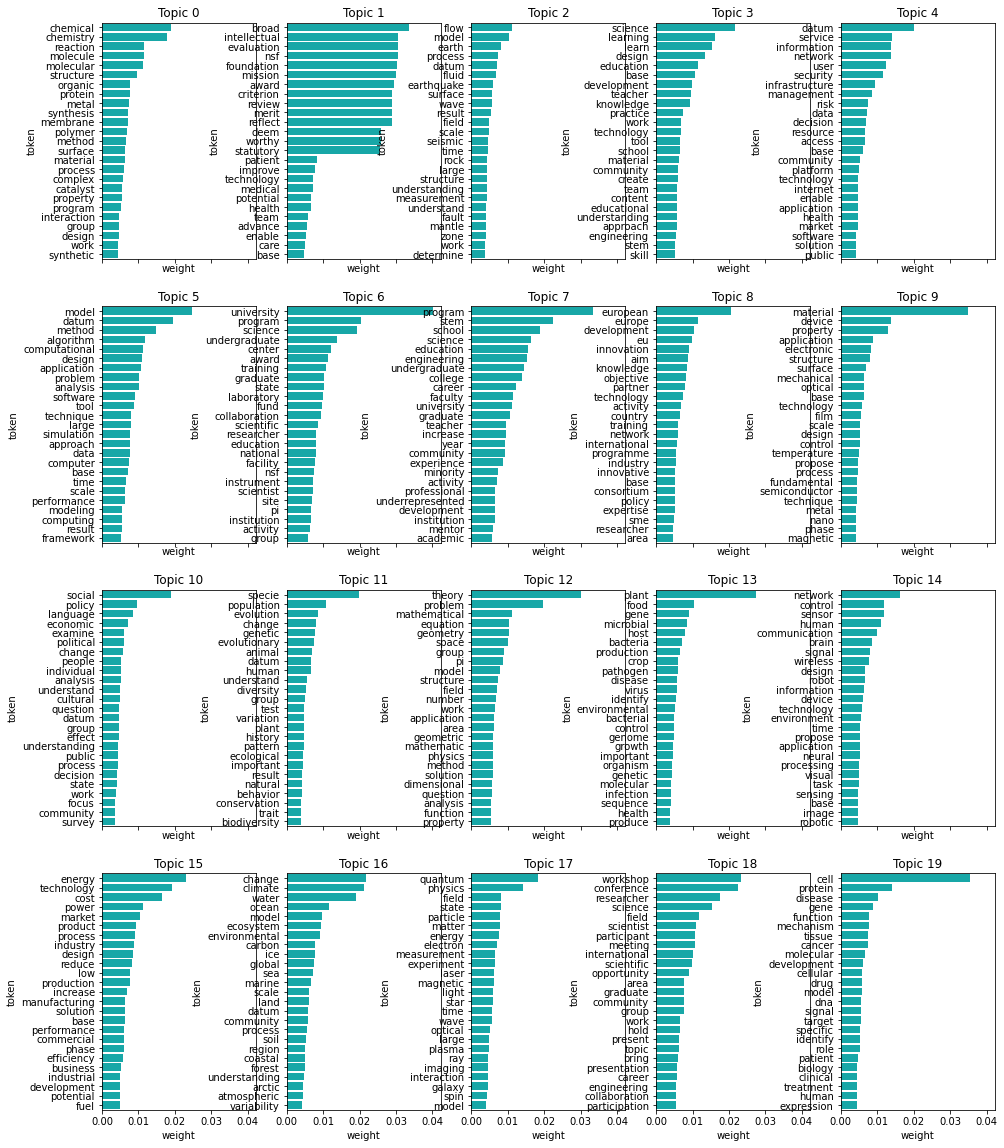

In [20]:
topn = 25 # top 25 words in each topic

fig, axes = plt.subplots(4, 5, figsize=(16, 20), sharex=True)

for i in range(5):

    # Build a dataframe with columns 'token' and 'weight' for topic i
    df = pd.DataFrame(ldamallet.show_topic(i, topn=topn), columns=['token','weight'])
    sns.barplot(x='weight', y='token', data=df, color='c', orient='h', ax=axes[0][i])
    axes[0][i].set_title('Topic ' + str(i))
    # Build a dataframe with columns 'token' and 'weight' for topic i + 5
    df = pd.DataFrame(ldamallet.show_topic(i+5, topn=topn), columns=['token','weight'])
    sns.barplot(x='weight', y='token', data=df, color='c', orient='h', ax=axes[1][i])
    axes[1][i].set_title('Topic ' + str(i+5))
    # Build a dataframe with columns 'token' and 'weight' for topic i + 10
    df = pd.DataFrame(ldamallet.show_topic(i+10, topn=topn), columns=['token','weight'])
    sns.barplot(x='weight', y='token', data=df, color='c', orient='h', ax=axes[2][i])
    axes[2][i].set_title('Topic ' + str(i+10))
    # Build a dataframe with columns 'token' and 'weight' for topic i + 15
    df = pd.DataFrame(ldamallet.show_topic(i + 15, topn=topn), columns=['token','weight'])
    sns.barplot(x='weight', y='token', data=df, color='c', orient='h', ax=axes[3][i])
    axes[3][i].set_title('Topic ' + str(i + 15))
    
plt.show()

In [21]:
mytopics20 = pd.DataFrame(columns=['topic','word'])

for i in range(len(ldamallet.show_topics(num_topics=topn,num_words=25,formatted=False))):
    for j in range(len(ldamallet.show_topics(num_topics=topn,num_words=25,formatted=False)[i][1])):
        new_row = {'topic':ldamallet.show_topics(num_topics=topn,num_words=25,formatted=False)[i][0],
                   'word':ldamallet.show_topics(num_topics=topn,num_words=25,formatted=False)[i][1][j][0]}
        mytopics20 = mytopics20.append(new_row,ignore_index=True)
        
mytopics20.to_excel('data/mytopics20.xlsx',index=False)

### 4.2 Cleaning vocabulary

In [ ]:
# count how many stopwords appear in each document

In [23]:
specific_stw = ['activity','aim','analysis','application','approach','area','award',
                'base','broad',
                'change','collection','community','complex','concept','condition','conference','content','context','cost','create','current',
                'data','datum','deem','design','development',
                'effect','enable','engineering','establish','eu','evaluation','examine','experience',
                'field','focus','foundation','formation','framework','function','fundamental',
                'goal','group',
                'human',
                'identify','important','improve','increase','information','innovation','intellectual','interaction','international','issue',
                'knowledge',
                'large','learn','learning','long','low',
                'main','management','material','mechanism','merit','meeting','method','middle','mission','model','modeling',
                'network','nsf','number',
                'objective','open','opportunity',
                'performance','phase','potential','present','problem','process','professional','programme','program','property','propose','public',
                'question',
                'real','reduce','reflect','researcher','resolution','response','result','review','role',
                'scale','science','scientist','scientific','service','small','solution','solve','specific','state','structure',
                'target','team','technique','technology','test','theory','time','tool','type',
                'underrepresented','understand','understanding','university',
                'work','workshop','worthy',
                'year']

def clean_lemmas(orig_str):
    lemmas = orig_str.lower().split()
    lemmas = [el for el in lemmas if el not in specific_stw]
    return ' '.join(lemmas)

corpusdata['clean_lemmas'] = corpusdata['lemmas'].apply(clean_lemmas)

#### 4.2.1 Remove again documents with few lemmas

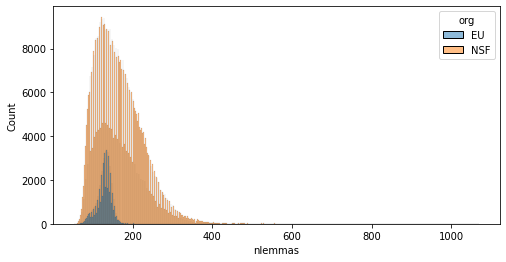

In [24]:
#We filter again according to the number of lemmas
corpusdata['nlemmas'] = corpusdata['clean_lemmas'].apply(count_lemmas)
fig, axes = plt.subplots(1, 1, figsize=(8, 4), sharex=True)
sns.histplot(data = corpusdata, x='nlemmas', hue='org')
plt.show()

In [25]:
corpusdata = corpusdata[corpusdata['nlemmas']>=100]
print('Number of projects in DataFrame after applying specific stopwords and removing short texts:', len(corpusdata))

Number of projects in DataFrame after applying specific stopwords and removing short texts: 612918


#### 4.2.2 Create dictionary again

In [26]:
mycorpus = corpusdata.clean_lemmas.tolist()
mycorpus = list(set(mycorpus)) # project order lost at this point
mycorpus = [el.split() for el in mycorpus]

# Create dictionary of tokens
D = gensim.corpora.Dictionary(mycorpus)
n_tokens = len(D)

print('The dictionary contains', n_tokens, 'terms')
print('First terms in the dictionary:')
for n in range(10):
    print(str(n), ':', D[n])

    
print('\nFiltering extremes...\n')
no_below = 5 #Minimum number of documents to keep a term in the dictionary
no_above = .4 #Maximum proportion of documents in which a term can appear to be kept in the dictionary

#D.filter_extremes(no_below=no_below,no_above=no_above, keep_n=25000)
D.filter_extremes(no_below=no_below,no_above=no_above) # keep all
n_tokens = len(D)

print('The dictionary contains', n_tokens, 'terms')

print('First terms in the dictionary:')
for n in range(10):
    print(str(n), ':', D[n])

The dictionary contains 230060 terms
First terms in the dictionary:
0 : achieve
1 : advance
2 : affect
3 : algorithm
4 : allow
5 : alternative
6 : api
7 : assist
8 : available
9 : boost
Filtering extremes...
The dictionary contains 55141 terms
First terms in the dictionary:
0 : achieve
1 : advance
2 : affect
3 : algorithm
4 : allow
5 : alternative
6 : api
7 : assist
8 : available
9 : boost


In [27]:
corpusdata.to_csv('data/corpusdata_clean_2.csv',sep=';',index=False)
D.save('clean_gensim_2.dict')

In [3]:
corpusdata = pd.read_csv('data/corpusdata_clean_2.csv',sep=';')
D = gensim.corpora.Dictionary.load('data/clean_gensim_2.dict')

#### 4.2.3 Create again bag of words

In [6]:
mycorpus = corpusdata.clean_lemmas.tolist()
mycorpus = list(set(mycorpus)) #Note that at this point we lose the project order
mycorpus = [el.split() for el in mycorpus]
mycorpus_bow = [D.doc2bow(doc) for doc in mycorpus]

### 4.3 Validating number of topics using coherence

In [4]:
tc = [0.5511522052483604, 0.6098384918306561, 0.6463367284101853, 0.6605222994606901, 0.658757253237484, 0.6664497055242967, 0.6740695033187606]

In [ ]:
#n_topics = [5, 10, 15, 20, 25, 35, 50, 75, 100, 150]
n_topics = [75, 100, 150]

#tc = []
for ntpc in n_topics:
    print('Estimating coherence for a model with', ntpc, 'topics')
    lda_ntpc = LdaMallet(mallet_path, corpus=mycorpus_bow, num_topics=ntpc, id2word=D, alpha=5, iterations=250)
    ldagensim = malletmodel2ldamodel(lda_ntpc)
    tc.append(CoherenceModel(ldagensim, texts=mycorpus, dictionary=D, coherence='c_v').get_coherence())
    print(tc)
    
plt.plot(n_topics, tc)
plt.xlabel('Number of topics')
plt.ylabel('Coherence')
plt.show()

print('Maximum coherence (%f) is achieved with %d topics' % (max(tc),n_topics[tc.index(max(tc))]))

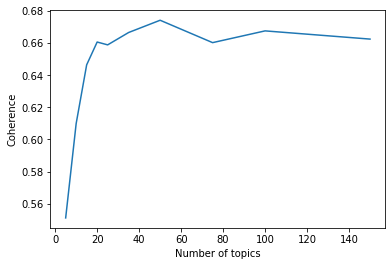

Maximum coherence (0.674070) is achieved with 50 topics


In [8]:
n_topics = [5, 10, 15, 20, 25, 35, 50, 75, 100, 150]
    
plt.plot(n_topics, tc)
plt.xlabel('Number of topics')
plt.ylabel('Coherence')
plt.show()

print('Maximum coherence (%f) is achieved with %d topics' % (max(tc),n_topics[tc.index(max(tc))]))

In [ ]:
tcfile = open("data/tc1.txt","w")
tcfile.write(str((tc)))
tcfile.close()

Estimating coherence for a model with 20 topics
[0.6433877557655385]
Estimating coherence for a model with 30 topics
[0.6433877557655385, 0.6670980753711311]
Estimating coherence for a model with 40 topics
[0.6433877557655385, 0.6670980753711311, 0.6702586497336218]
Estimating coherence for a model with 50 topics
[0.6433877557655385, 0.6670980753711311, 0.6702586497336218, 0.6747723235758742]


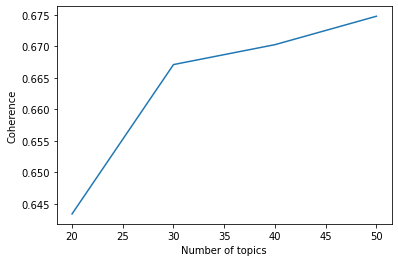

Maximum coherence (0.674772) is achieved with 50 topics


In [10]:
n_topics = [20,30,40,50]

tc = []
for ntpc in n_topics:
    print('Estimating coherence for a model with', ntpc, 'topics')
    lda_ntpc = LdaMallet(mallet_path, corpus=mycorpus_bow, num_topics=ntpc, id2word=D, alpha=5, iterations=250)
    ldagensim = malletmodel2ldamodel(lda_ntpc)
    tc.append(CoherenceModel(ldagensim, texts=mycorpus, dictionary=D, coherence='c_v').get_coherence())
    print(tc)
    
plt.plot(n_topics, tc)
plt.xlabel('Number of topics')
plt.ylabel('Coherence')
plt.show()

print('Maximum coherence (%f) is achieved with %d topics' % (max(tc),n_topics[tc.index(max(tc))]))

In [11]:
tcfile = open("data/tc2.txt","w")
tcfile.write(str((tc)))
tcfile.close()

Estimating coherence for a model with 35 topics
[0.6644658167907392]
Estimating coherence for a model with 40 topics
[0.6644658167907392, 0.6728383372944762]
Estimating coherence for a model with 45 topics
[0.6644658167907392, 0.6728383372944762, 0.6646489991937281]
Estimating coherence for a model with 50 topics
[0.6644658167907392, 0.6728383372944762, 0.6646489991937281, 0.674980746635707]
Estimating coherence for a model with 55 topics
[0.6644658167907392, 0.6728383372944762, 0.6646489991937281, 0.674980746635707, 0.6664972055711099]


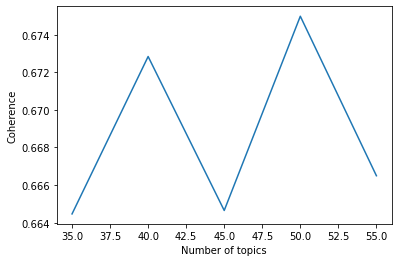

Maximum coherence (0.674981) is achieved with 50 topics


In [12]:
n_topics = [35,40,45,50,55]

tc = []
for ntpc in n_topics:
    print('Estimating coherence for a model with', ntpc, 'topics')
    lda_ntpc = LdaMallet(mallet_path, corpus=mycorpus_bow, num_topics=ntpc, id2word=D, alpha=5, iterations=250)
    ldagensim = malletmodel2ldamodel(lda_ntpc)
    tc.append(CoherenceModel(ldagensim, texts=mycorpus, dictionary=D, coherence='c_v').get_coherence())
    print(tc)
    
plt.plot(n_topics, tc)
plt.xlabel('Number of topics')
plt.ylabel('Coherence')
plt.show()

print('Maximum coherence (%f) is achieved with %d topics' % (max(tc),n_topics[tc.index(max(tc))]))

In [13]:
tcfile = open("data/tc3.txt","w")
tcfile.write(str((tc)))
tcfile.close()

In [ ]:
n_topics = [5, 10, 15, 20, 25, 35, 50, 75, 100, 150]
iterations = 3 #10, 20...
tc = pd.DataFrame(columns=['ntpcs','mean','sd'])

for ntpc in n_topics:
    print('Estimating coherence for a model with', ntpc, 'topics')
    coherences = np.array([])
    for i in range(iterations):
        #lda_ntpc = LdaMallet(mallet_path, corpus=mycorpus_bow, num_topics=ntpc, id2word=D, alpha=5, iterations=250)
        lda_ntpc = LdaMallet(mallet_path, corpus=mycorpus_bow, num_topics=ntpc, id2word=D, alpha=5, iterations=100)
        ldagensim = malletmodel2ldamodel(lda_ntpc)
        coherence = CoherenceModel(ldagensim, texts=mycorpus, dictionary=D, coherence='c_v').get_coherence()
        coherences = np.append(coherences,coherence)
    print(coherences)
    tc.loc[n_topics.index(ntpc)] = [ntpc,np.mean(coherences),np.std(coherences)]

tc.to_csv('data/tc3.csv',sep=';',index=False)
    
plt.plot(n_topics, tc['mean'])
plt.fill_between(range(1,len(n_topics)+1),tc['mean']-tc['sd'],tc['mean']+tc['sd'],alpha=0.2)
plt.xlabel('Number of topics')
plt.ylabel('Average coherence')
plt.show()

print('Maximum coherence (%f) is achieved with %d topics' % (tc['mean'].max(),n_topics[tc['mean'].idxmax()]))

### 4.4 Document LDA representation

In [ ]:
#mycorpus = pd.read_excel('corpusdata_clean_2.xlsx')
#mycorpus_bow = gensim.corpora.Dictionary.load('clean_gensim_2.dict')

In [ ]:
ldamallet = LdaMallet(mallet_path, corpus=mycorpus_bow, num_topics=50, id2word=D, alpha=5, iterations=1000)

In [ ]:
mytopics = pd.DataFrame(columns=['topic','word'])
topn = 50 # TBD

for i in range(len(ldamallet.show_topics(num_topics=topn,num_words=25,formatted=False))):
    for j in range(len(ldamallet.show_topics(num_topics=topn,num_words=25,formatted=False)[i][1])):
        new_row = {'topic':ldamallet.show_topics(num_topics=topn,num_words=25,formatted=False)[i][0],
                   'word':ldamallet.show_topics(num_topics=topn,num_words=25,formatted=False)[i][1][j][0]}
        mytopics = mytopics.append(new_row,ignore_index=True)
        
mytopics.to_excel('data/mytopics50.xlsx',index=False)

In [ ]:
ldagensim = malletmodel2ldamodel(ldamallet)
vis_data = gensimvis.prepare(ldagensim, mycorpus_bow, D)
pyLDAvis.display(vis_data)

In [ ]:
tpc_descriptions = []

for ntpc in range(50):
    print(ldagensim.show_topic(ntpc, topn=20))
    desc = input('Introduce a label for topic ' + str(ntpc) + ': ')
    tpc_descriptions.append(desc)

In [ ]:
mycorpus_lda = [ldagensim[el] for el in mycorpus_bow]

In [ ]:
main_topic = [tpc_descriptions[sorted(el,key=lambda x: -x[-1])[0][0]] for el in mycorpus_lda]

In [ ]:
corpusdata['LDA_50'] = mycorpus_lda
corpusdata['main_topic_50'] = main_topic